In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import itertools as it
import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn import manifold as mfold
from sklearn import model_selection as mselection
from sklearn import feature_selection as fselection
from sklearn import metrics as mets
from sklearn import linear_model as lmodel

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [2]:
iniN = 3
endN = 52

src = '../hpcc/traditional/'
dst = '../hpcc/results/trad/'

In [3]:
perbasis = 'accession'
filename = src + 'qual_quant_' + perbasis + '_summary.csv'
df = pd.read_csv(filename)

df = df.drop(index = df[df['PercentKernel'] == -1].index)
df['TipShrivel'] /= 100
df['MinorShrivel'] /= 100
df['MajorShrivel'] /= 100
df['PercentKernel'] /= 100

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]
colnames = df.columns

for i in range(len(colnames)):
    if 'm' in labels.col_units[i]:
        df[colnames[i]] = np.log(df[colnames[i]])

earliest = df[df['EaseOfRemoval'] == 7.5].index.values
data = df.drop(index=earliest)

#lowN = data[data['nut_count'] < 5].index.values
#data = data.drop(index=lowN)

print(df.shape, data.shape)

N = 1000
arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))

choice = np.zeros((N,testN), dtype=int)
nonchoice = np.zeros((N, len(data) - testN), dtype=int)

for j in range(N):
    rng = np.random.default_rng(j)
    choice[j] = rng.choice(arr, testN, replace=False)
    nonchoice[j] = np.setxor1d(arr, choice[j])
    
df.head()

(67, 2)
(149, 67) (148, 67)


,UCACCSD,nut_count,plot_count,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_area,...,ShellThickness,PackingTissue,KernelFill,TipShrivel,MinorShrivel,MajorShrivel,Plumpness,EaseOfRemoval,PercentKernel,Blank
0,03-001-3395,6,4,3.722851,3.542478,3.546267,10.049243,5.061907,1.205837,8.815960,...,1.075000,5.000000,4.750000,0.000000,0.000000,0.0,4.750000,4.500000,0.623294,0.000000
1,04-004-626,9,1,3.729445,3.590846,3.518564,10.104634,4.624070,1.234757,8.822320,...,1.100000,5.000000,6.000000,0.000000,0.000000,0.0,4.000000,5.000000,0.583988,0.000000
2,06-004-4,16,7,3.612844,3.555183,3.480330,9.937941,4.320171,1.151675,8.687401,...,1.114286,5.000000,5.000000,0.000000,0.031746,0.0,3.857143,4.857143,0.589313,5.714286
3,06-005-27,15,4,3.701885,3.504070,3.436651,9.901554,4.605803,1.304487,8.685413,...,1.475000,5.750000,5.250000,0.000000,0.000000,0.0,3.500000,5.750000,0.482632,2.500000
4,06-030-18,5,3,3.635503,3.496012,3.452446,9.831883,4.443319,1.201473,8.627431,...,1.233333,5.666667,5.666667,0.033333,0.000000,0.0,5.000000,5.666667,0.461030,0.000000


# Choose target variable

In [4]:
data.columns[endN:]

Index(['ShellIntegrity', 'ShellTexture', 'ShellColor', 'SEAL', 'ShellStrength',
       'ShellThickness', 'PackingTissue', 'KernelFill', 'TipShrivel',
       'MinorShrivel', 'MajorShrivel', 'Plumpness', 'EaseOfRemoval',
       'PercentKernel', 'Blank'],
      dtype='object')

../hpcc/results/trad/easeofremoval_value_histogram


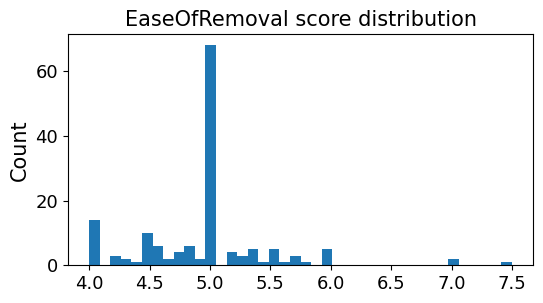

In [4]:
yvalue = 'EaseOfRemoval'
y1 = df[yvalue].values.copy()

fs = 15
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.hist(y1,bins=40, density=False)
ax.set_title(yvalue + ' score distribution', fontsize=fs)
ax.set_ylabel('Count', fontsize=fs);
ax.tick_params(labelsize=fs-2);

filename = dst + yvalue.lower().replace(' ','_') + '_value_histogram'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
print(filename)

# Spearman correlation

In [5]:
scorrstat = np.ones(endN - iniN)
spvalcorr = np.zeros_like(scorrstat)

for i in range(len(scorrstat)):
    x = df.iloc[:, iniN+i].values
    dof = len(x)-2
    sstat, spval = stats.spearmanr(x, y1)
    #def statistic(x):  # explore all possible pairings by permuting `x`
    #    rs = stats.spearmanr(x, y).statistic  # ignore pvalue
    #    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    #    return transformed
    #ref = stats.permutation_test((x,), statistic, alternative='greater', permutation_type='pairings')

    scorrstat[i] = sstat
    spvalcorr[i] = spval

In [6]:
s_thr = 0.05
s_mask = np.nonzero(spvalcorr < s_thr)[0]
foo = scorrstat[s_mask]
bar = np.argsort(np.abs(foo))[::-1]

for i in range(len(s_mask)):
    print(i+1, -np.log10(spvalcorr[s_mask[bar[i]]]), 
          foo[bar[i]], labels.col_labels.iloc[iniN + s_mask[bar[i]]], sep='\t')

1	7.4995562767427835	0.43417698253863507	Shell Vol Ratio
2	6.452956762084338	-0.4028146040128285	Air Vol Ratio
3	6.452351928117571	0.4027955224975413	Shell Thickness
4	4.94998308010697	0.3512487171010859	Protruding Shell Volume
5	4.487449279585654	-0.33339605139851547	Kernel Vol Ratio wo Air
6	4.399827203214481	0.32988696073722573	Packing Vol Ratio
7	4.340264649171748	-0.32747696535647036	Density Kernel vs Shell
8	3.962607577506106	0.3117041848201892	Shell Vol Ratio wo Air
9	3.6323297978504163	0.29714689680769346	Protruding Shell Ratio
10	3.041769403894803	-0.2690169269715142	Air Volume
11	2.8912152244989846	0.26134424967458864	Density Packing vs Kernel
12	2.7180069028399547	0.25222710167043283	Shell Volume
13	2.4837733764348013	-0.23935471145778425	Kernel Ratio Convex Area
14	1.7225453717884158	-0.19206880842492854	Kernel Ratio Cavity Area


# Find best regularization parameter for Lasso regression

In [7]:
X = data.iloc[:,iniN + s_mask].values.copy()
y = data[yvalue].values.copy()

Xscaler = prep.StandardScaler().fit(X)
X = Xscaler.transform(X)

In [8]:
rng = np.random.default_rng()

cho = rng.choice(arr, testN, replace=False)
non = np.setxor1d(arr, cho)

X_train, y_train = X[cho].copy(), y[cho].copy()
X_test, y_test = X[non].copy(), y[non].copy()

#ridge = lmodel.Ridge(alpha=alpha).fit(X_train, y_train)
ridge = lmodel.Lasso(alpha=0.005).fit(X_train, y_train)
r2_train = ridge.score(X_train, y_train)

y_pred = ridge.predict(X_test)
r2_test = mets.r2_score(y_test, y_pred)

print('Train:\t',r2_train,'\nTest:\t',r2_test)

Train:	 0.5671444475581546 
Test:	 -0.5995806701354052


In [10]:
N = 1000
alphas = np.linspace(0.005, 0.1, 20)
describe = np.zeros((len(alphas), 8, 2))


for j in range(len(alphas)):
    alpha = alphas[j]
    R2 = np.zeros((N,2))

    for i in range(N):    
        rng = np.random.default_rng(i)
        
        X_train, y_train = X[choice[i]].copy(), y[choice[i]].copy()
        X_test, y_test = X[nonchoice[i]].copy(), y[nonchoice[i]].copy()

        ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
        r2_train = ridge.score(X_train, y_train)

        y_pred = ridge.predict(X_test)
        r2_test = mets.r2_score(y_test, y_pred)
        R2[i] = [r2_train, r2_test]
    
    describe[j] = pd.DataFrame(R2, columns=['Train', 'Test']).describe().values

In [12]:
print('optimal alpha: ', alphas[np.argmax(describe[:,1,1])])
print(describe[np.argmax(describe[:,1,1])])

optimal alpha:  0.025
[[ 1.00000000e+03  1.00000000e+03]
 [ 4.33866947e-01  2.89888772e-01]
 [ 5.67968866e-02  1.57633020e-01]
 [ 2.41617764e-01 -5.35897473e-01]
 [ 4.00662017e-01  2.02288406e-01]
 [ 4.40685208e-01  3.19337167e-01]
 [ 4.74488669e-01  4.03716393e-01]
 [ 5.89629875e-01  5.72511633e-01]]


../hpcc/results/trad/ease_of_removal_lasso_7030_optimal


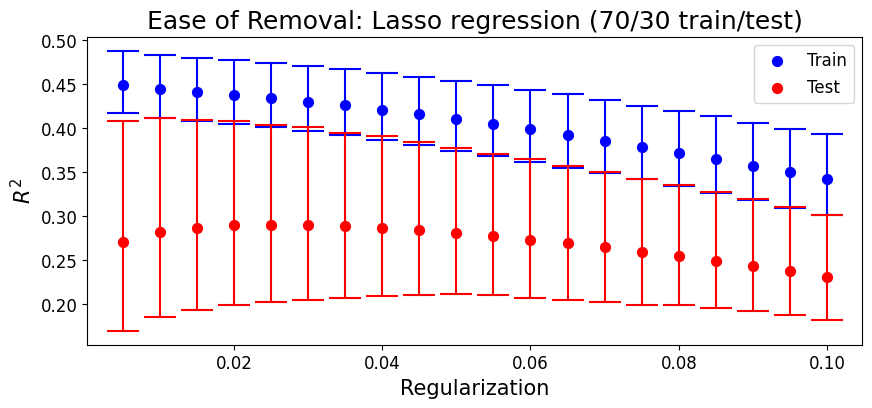

In [13]:
reg = str(type(ridge)).split('.')[-1][:-2]
fs = 15
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax = np.atleast_1d(ax).ravel(); i=0
c = ['blue','red']
l = ['Train','Test']
for j in range(2):
    ax[i].scatter(alphas, describe[:,1,j], color=c[j], label=l[j], s=50)
    ax[i].scatter(alphas, describe[:,4,j], color=c[j], marker='_', s=500)
    ax[i].scatter(alphas, describe[:,6,j], color=c[j], marker='_', s=500)
    for k in range(len(alphas)):
        ax[i].plot([alphas[k], alphas[k]], describe[k,[4,6],j], color=c[j])

ax[i].set_ylabel('$R^2$', fontsize=fs, rotation=90)
ax[i].set_xlabel('Regularization', fontsize=fs)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_title(yvalue + ': ' + reg +' regression (70/30 train/test)', fontsize=fs+3)
ax[i].legend(fontsize=fs-3);

filename = dst + yvalue.lower().replace(' ','_') + '_' + reg.lower()+ '_7030_optimal'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
print(filename)

# Fix $\alpha$ and explore the most relevant coefficients

In [9]:
N = 1000
#alpha = alphas[np.argmax(describe[:,1,1])]
alpha = 0.025
yvalue = 'Ease of Removal'
R2 = np.zeros((N,2))
coefs = np.zeros((N,X.shape[1]))

for i in range(N):    
    X_train, y_train = X[choice[i]].copy(), y[choice[i]].copy()
    X_test, y_test = X[nonchoice[i]].copy(), y[nonchoice[i]].copy()

    ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
    r2_train = ridge.score(X_train, y_train)

    y_pred = ridge.predict(X_test)
    r2_test = mets.r2_score(y_test, y_pred)
    R2[i] = [r2_train, r2_test]
    coefs[i] = ridge.coef_

../hpcc/results/trad/ease_of_removal_optimal_lasso_R2_train_vs_test


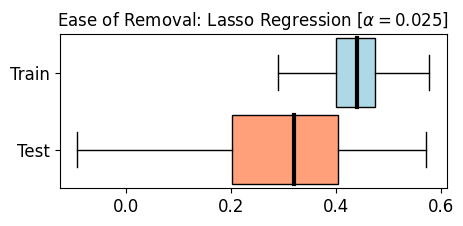

In [11]:
fs = 12
reg = str(type(ridge)).split('.')[-1][:-2]

fig, ax = plt.subplots(1,1,figsize=(5,2))
colors = ['lightsalmon','lightblue']
bplot = ax.boxplot(np.flip(R2), notch=False, sym='', vert=False, widths=0.9, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, labels=['Test', 'Train'])

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
ax.set_title(yvalue + ': ' + reg + ' Regression [$\\alpha=${}]'.format(ridge.alpha), fontsize=fs);
ax.tick_params(labelsize=fs)
filename = dst + yvalue.lower().replace(' ','_') + '_optimal_' + reg.lower() + '_R2_train_vs_test'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
print(filename)

../hpcc/results/trad/ease_of_removal_lasso_coefs


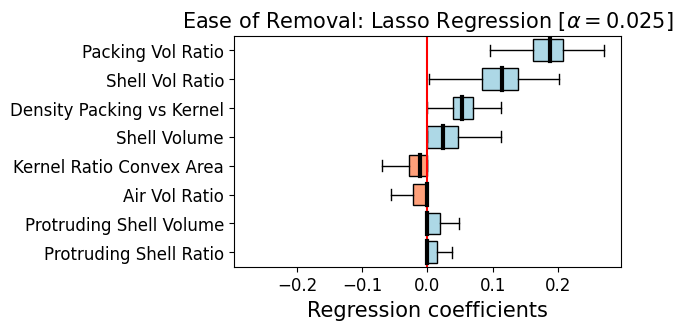

In [12]:
fs = 15
fabs = np.abs(np.mean(coefs, axis=0))
r_mask = fabs > 0.01
aabs = np.argsort(fabs[r_mask])
mabs = np.mean(coefs[:,r_mask][:,aabs], axis=0)

fig, ax = plt.subplots(1,1,figsize=(5,3))

colors = ['lightsalmon','lightblue']

bplot = ax.boxplot(coefs[:,r_mask][:,aabs], notch=False, sym='', vert=False, widths=0.75, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'},
                   labels = labels.col_labels.iloc[iniN+s_mask].iloc[r_mask].iloc[aabs])
ax.scatter([-np.max(coefs), np.max(coefs)], [5,5], c='w', alpha=0)

for i,patch in enumerate(bplot['boxes']):
    if mabs[i] > 0:
        patch.set_facecolor(colors[1])
    else:
        patch.set_facecolor(colors[0])

ax.axvline(0, c='r')
ax.set_title(yvalue + ': ' + reg + ' Regression [$\\alpha=${}]'.format(ridge.alpha), fontsize=fs)
ax.set_xlabel('Regression coefficients', fontsize=fs)
ax.tick_params(labelsize=fs-3)

filename = dst + yvalue.lower().replace(' ','_') + '_' + reg.lower() + '_coefs'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
print(filename)

# Feature selection

In [13]:
X = Xscaler.transform(data.iloc[:,iniN + s_mask].values.copy())
X = X[:, r_mask]

N = 100
M = X.shape[1]

dict22 = [{} for i in range(M)]


for i in range(X.shape[1]):
    R2 = np.zeros((N,2))
    X1 = X[:,i].copy()

    for j in range(N):
        X_train, y_train = X1[choice[j]].copy().reshape(-1,1), y[choice[j]].copy()
        X_test, y_test = X1[nonchoice[j]].copy().reshape(-1,1), y[nonchoice[j]].copy()

        ridge = lmodel.LinearRegression().fit(X_train, y_train)
        R2[j,0] = ridge.score(X_train, y_train)

        y_pred = ridge.predict(X_test)
        R2[j,1] = mets.r2_score(y_test, y_pred)

    dict22[0][(i,)] = R2

In [14]:
for i in range(1,M):
    for comb in it.combinations(range(X.shape[1]), i+1):
        R2 = np.zeros((N,2))
        arrcomb = np.array(comb)
        X1 = X[:,arrcomb].copy()
        
        for j in range(N):
            X_train, y_train = X1[choice[j]].copy(), y[choice[j]].copy()
            X_test, y_test = X1[nonchoice[j]].copy(), y[nonchoice[j]].copy()

            ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
            R2[j,0] = ridge.score(X_train, y_train)

            y_pred = ridge.predict(X_test)
            R2[j,1] = mets.r2_score(y_test, y_pred)
            
        dict22[i][comb] = R2

../hpcc/results/trad/ease_of_removal_lasso_7030


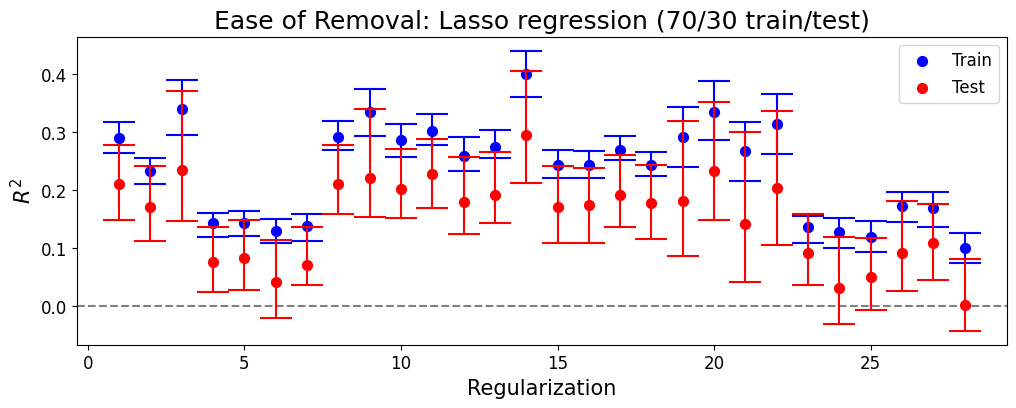

In [15]:
k = 1
describe = np.zeros((len(dict22[k]), 8, 2 ))
for i,key in enumerate(dict22[k]):
    describe[i] = pd.DataFrame(dict22[k][key]).describe().values

fs = 15
xaxis = np.arange(len(describe)) + 1
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax = np.atleast_1d(ax).ravel(); i=0

c = ['blue','red']
l = ['Train','Test']

for j in range(2):
    ax[i].scatter(xaxis, describe[:,1,j], color=c[j], label=l[j], s=50)
    ax[i].scatter(xaxis, describe[:,4,j], color=c[j], marker='_', s=500)
    ax[i].scatter(xaxis, describe[:,6,j], color=c[j], marker='_', s=500)
    for k in range(len(xaxis)):
        ax[i].plot([xaxis[k], xaxis[k]], describe[k,[4,6],j], color=c[j])

ax[i].axhline(0, c='gray', ls='--', zorder=-1)
ax[i].set_ylabel('$R^2$', fontsize=fs, rotation=90)
ax[i].set_xlabel('Regularization', fontsize=fs)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_title(yvalue + ': ' + reg +' regression (70/30 train/test)', fontsize=fs+3)
ax[i].legend(fontsize=fs-3);

filename = dst + yvalue.lower().replace(' ','_') + '_' + reg.lower()+ '_7030'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
print(filename)

In [16]:
maxR2 = [{} for i in range(M)]
maxargs = [None for i in range(M)]
maxvals = np.zeros(M)

for k in range(len(maxR2)):
    for key in dict22[k]:
        maxR2[k][key] = np.mean(dict22[k][key], axis = 0)

    maxval = 0
    for key in dict22[k]:
        val = maxR2[k][key][1]
        if val > maxval:
            maxval = val
            maxarg = key
    
    maxargs[k] = maxarg
    maxvals[k] = maxval
    
    print(maxarg, maxval, maxR2[k][maxarg])
    print(labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[np.array(maxarg)], '\n')

(1,) 0.1825544996460579 [0.26004459 0.1825545 ]
21    Air Vol Ratio
Name: col_labels, dtype: object 

(2, 3) 0.2943672675081712 [0.39940205 0.29436727]
23      Shell Vol Ratio
24    Packing Vol Ratio
Name: col_labels, dtype: object 

(2, 3, 7) 0.30298695191761554 [0.41794144 0.30298695]
23              Shell Vol Ratio
24            Packing Vol Ratio
46    Density Packing vs Kernel
Name: col_labels, dtype: object 

(0, 2, 3, 7) 0.3025402570594984 [0.42676448 0.30254026]
19                 Shell Volume
23              Shell Vol Ratio
24            Packing Vol Ratio
46    Density Packing vs Kernel
Name: col_labels, dtype: object 

(2, 3, 4, 5, 7) 0.2962456142612819 [0.42474773 0.29624561]
23              Shell Vol Ratio
24            Packing Vol Ratio
27       Protruding Shell Ratio
28      Protruding Shell Volume
46    Density Packing vs Kernel
Name: col_labels, dtype: object 

(0, 2, 3, 4, 5, 7) 0.29323121000307834 [0.43053623 0.29323121]
19                 Shell Volume
23              

In [17]:
boxtrain = np.zeros((N,M))
boxtest  = np.zeros((N,M))

for k in range(M):
    boxtrain[:,k] = dict22[k][maxargs[k]][:,0]
    boxtest[:,k] = dict22[k][maxargs[k]][:,1]

In [18]:
img = np.zeros((M,M), dtype=bool)
for k in range(M):
    img[k, np.array(maxargs[k])] = True
    
foo = np.array(np.nonzero(img.T))
foo = np.array([np.min(foo[:, foo[0]==k][1]) for k in range(M)])*.1
argsum = np.argsort(np.sum(img, axis=0) - foo)[::-1]

../hpcc/results/trad/ease_of_removal_OLS_optimal_features


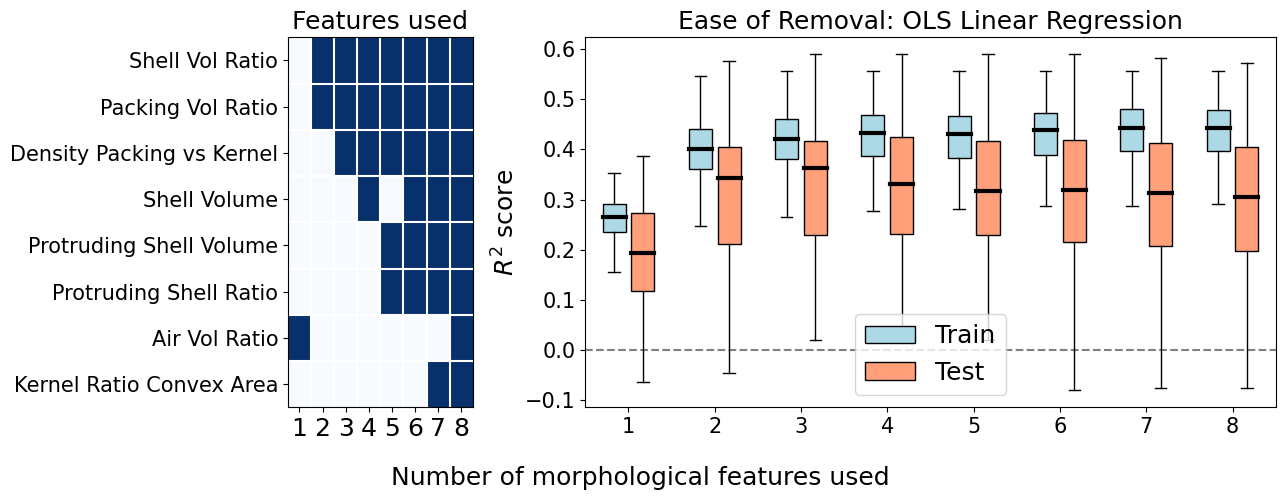

In [19]:
fs = 18
vert = True

fig, ax = plt.subplots(1,2,figsize=(13,5), width_ratios=[1,3])
ax = np.atleast_1d(ax).ravel()

i = 0

ax[i].imshow(img.T[argsum], cmap='Blues')
for k in range(M-1):
    ax[i].axhline(k+0.5, c='w')
    ax[i].axvline(k+0.5, c='w')

ax[i].set_aspect(2)
ax[i].set_yticks(range(M), labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[argsum].values, fontsize=fs-3)
ax[i].set_xticks(range(M), 1+np.arange(M), fontsize=fs);
ax[i].set_title('Features used', fontsize=fs)

i = 1

bp1 = ax[i].boxplot(boxtrain, notch=False, sym='', vert=vert, widths=0.4, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, positions=1.5*np.arange(M)-0.25)
for patch in bp1['boxes']:
        patch.set_facecolor(colors[1])
        
bp2 = ax[i].boxplot(boxtest, notch=False, sym='', vert=vert, widths=0.4, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, positions=1.5*np.arange(M)+0.25)
for patch in bp2['boxes']:
        patch.set_facecolor(colors[0])
ax[i].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Train', 'Test'], loc='lower center', fontsize=fs)
ax[i].axhline(0, c='gray', zorder=0, ls='--')
ax[i].set_xticks(1.5*np.arange(M), 1+np.arange(M))
ax[i].set_ylabel('$R^2$ score', fontsize=fs)
ax[i].tick_params(labelsize=fs-3);
ax[i].set_title(yvalue + ': OLS Linear Regression', fontsize=fs)

fig.supxlabel('Number of morphological features used', fontsize=fs)

fig.tight_layout();

filename = dst + yvalue.lower().replace(' ','_') + '_OLS_optimal_features'
print(filename)
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

In [79]:
uq, idx = np.unique(np.hstack(maxargs), return_index=True)
argsum = uq[np.argsort(idx)]

../hpcc/results/trad/ease_of_removal_OLS_optimal_features_ver2


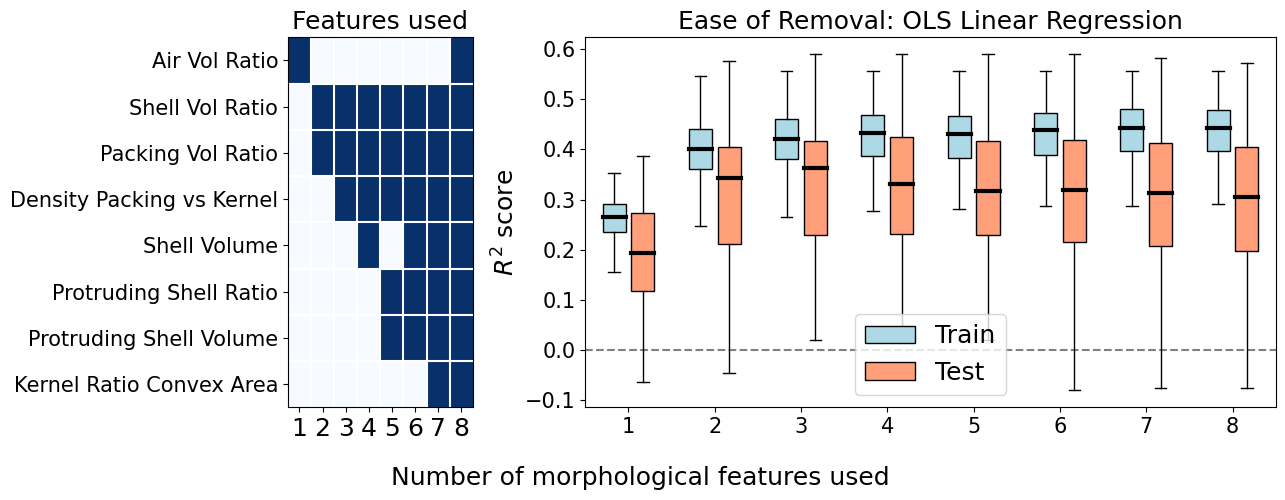

In [81]:
fs = 18
vert = True

fig, ax = plt.subplots(1,2,figsize=(13,5), width_ratios=[1,3])
ax = np.atleast_1d(ax).ravel()

i = 0

ax[i].imshow(img.T[argsum], cmap='Blues')
for k in range(M-1):
    ax[i].axhline(k+0.5, c='w')
    ax[i].axvline(k+0.5, c='w')

ax[i].set_aspect(2)
ax[i].set_yticks(range(M), labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[argsum].values, fontsize=fs-3)
ax[i].set_xticks(range(M), 1+np.arange(M), fontsize=fs);
ax[i].set_title('Features used', fontsize=fs)

i = 1

bp1 = ax[i].boxplot(boxtrain, notch=False, sym='', vert=vert, widths=0.4, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, positions=1.5*np.arange(M)-0.25)
for patch in bp1['boxes']:
        patch.set_facecolor(colors[1])
        
bp2 = ax[i].boxplot(boxtest, notch=False, sym='', vert=vert, widths=0.4, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, positions=1.5*np.arange(M)+0.25)
for patch in bp2['boxes']:
        patch.set_facecolor(colors[0])
ax[i].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Train', 'Test'], loc='lower center', fontsize=fs)
ax[i].axhline(0, c='gray', zorder=0, ls='--')
ax[i].set_xticks(1.5*np.arange(M), 1+np.arange(M))
ax[i].set_ylabel('$R^2$ score', fontsize=fs)
ax[i].tick_params(labelsize=fs-3);
ax[i].set_title(yvalue + ': OLS Linear Regression', fontsize=fs)

fig.supxlabel('Number of morphological features used', fontsize=fs)

fig.tight_layout();

filename = dst + yvalue.lower().replace(' ','_') + '_OLS_optimal_features_ver2'
print(filename)
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

In [68]:
argsum

array([2, 3, 7, 0, 5, 4, 1, 6])

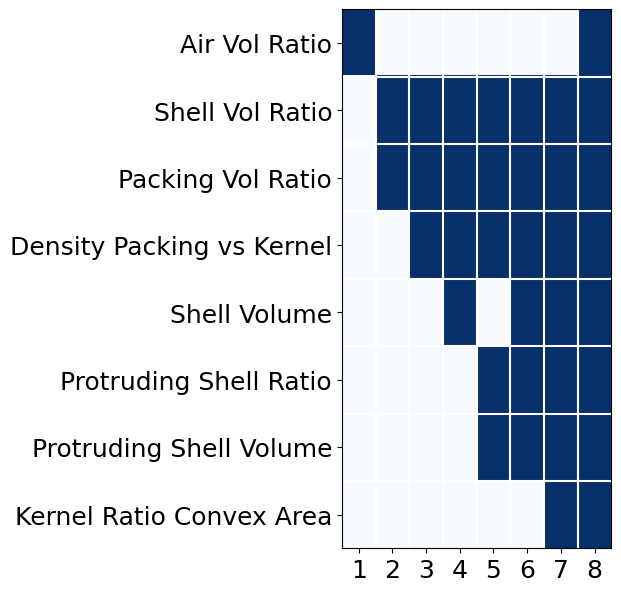

In [78]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax = np.atleast_1d(ax).ravel(); i=0

ax[i].imshow(img.T[argsum], cmap='Blues')
for k in range(M-1):
    ax[i].axhline(k+0.5, c='w')
    ax[i].axvline(k+0.5, c='w')

ax[i].set_aspect(2)
ax[i].set_yticks(range(M), labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[argsum].values, fontsize=fs)
ax[i].set_xticks(range(M), 1+np.arange(M), fontsize=fs);
#ax[i].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False);